# Imports

In [57]:
# !pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
import polars as pl
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import keras
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from time import time
import numpy as np
from sklearn.svm import LinearSVC, SVC
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# Dataset

In [2]:
data = pd.read_csv("/kaggle/input/cleaned-malware-detection/Cleaned_malware.csv", low_memory=False)
data.head()

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,5,000016191b897145d069102325cab760,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1094.0,0,7.0,0,53447.0,...,51039.0,0,0.0,0.0,0,0,0.0,0.0,15.0,1
1,7,000019515bc8f95851aff6de873405e8,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1393.0,0,7.0,0,53447.0,...,63122.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
2,8,00001a027a0ab970c408182df8484fce,win8defender,1.1.15200.1,4.18.1807.18075,1.275.988.0,0,7.0,0,53447.0,...,15510.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
3,15,000027c68b89acb49d4017763b043449,win8defender,1.1.15200.1,4.18.1807.18075,1.275.130.0,0,7.0,0,47238.0,...,19951.0,1,0.0,0.0,0,0,0.0,0.0,1.0,1
4,24,000038f24a1ee98931456b3e49f7934b,win8defender,1.1.15200.1,4.18.1806.18062,1.275.879.0,0,7.0,0,53447.0,...,51032.0,0,0.0,0.0,0,0,0.0,0.0,7.0,0


In [3]:
data.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823550 entries, 0 to 1823549
Data columns (total 78 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   MachineIdentifier                                  object 
 1   ProductName                                        object 
 2   EngineVersion                                      object 
 3   AppVersion                                         object 
 4   AvSigVersion                                       object 
 5   IsBeta                                             int64  
 6   RtpStateBitfield                                   float64
 7   IsSxsPassiveMode                                   int64  
 8   AVProductStatesIdentifier                          float64
 9   AVProductsInstalled                                float64
 10  AVProductsEnabled                                  float64
 11  HasTpm                                            

In [5]:
data.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,...,1.823550e+06,1.823550e+06,1823550.0,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06,1.823550e+06
mean,2.193524e-06,6.847975e+00,1.676017e-02,4.701612e+04,1.383484e+00,1.026553e+00,9.989625e-01,1.069236e+02,8.060299e+04,2.484157e+01,...,3.413802e+04,5.144592e-01,0.0,1.355598e-03,1.460031e-01,3.628362e-02,6.411066e-02,2.223334e-01,8.322673e+00,4.987135e-01
std,1.481054e-03,1.006668e+00,1.283716e-01,1.470503e+04,5.430370e-01,1.835109e-01,3.219411e-02,6.277194e+01,4.913968e+04,5.195289e+00,...,2.095789e+04,4.997910e-01,0.0,3.679349e-02,3.531094e-01,1.869950e-01,2.449500e-01,4.158141e-01,4.477974e+00,4.999985e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.000000e+00,1.000000e+00,...,8.700000e+01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,7.000000e+00,0.000000e+00,4.681000e+04,1.000000e+00,1.000000e+00,1.000000e+00,5.100000e+01,3.480900e+04,1.800000e+01,...,1.704100e+04,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
50%,0.000000e+00,7.000000e+00,0.000000e+00,5.344700e+04,1.000000e+00,1.000000e+00,1.000000e+00,9.400000e+01,8.237300e+04,2.700000e+01,...,3.307000e+04,1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00
75%,0.000000e+00,7.000000e+00,0.000000e+00,5.344700e+04,2.000000e+00,1.000000e+00,1.000000e+00,1.600000e+02,1.241500e+05,2.700000e+01,...,5.289700e+04,1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01,1.000000e+00
max,1.000000e+00,8.000000e+00,1.000000e+00,7.049800e+04,6.000000e+00,5.000000e+00,1.000000e+00,2.220000e+02,1.679620e+05,5.200000e+01,...,7.209600e+04,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e+01,1.000000e+00


# Data Cleaning

In [6]:
data.isna()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823545,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1823546,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1823547,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1823548,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# data["Census_IsAlwaysOnAlwaysConnectedCapable"].isnull().sum() / len(data)

In [8]:
# data.columns[0]

In [9]:
# for c in data.columns:
#     if ((data[c].isnull().sum() * 100) / len(data)) > 70:
#         data.drop(c, inplace=True, axis = 1)

In [10]:
data.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,000016191b897145d069102325cab760,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1094.0,0,7.0,0,53447.0,1.0,...,51039.0,0,0.0,0.0,0,0,0.0,0.0,15.0,1
1,000019515bc8f95851aff6de873405e8,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1393.0,0,7.0,0,53447.0,1.0,...,63122.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
2,00001a027a0ab970c408182df8484fce,win8defender,1.1.15200.1,4.18.1807.18075,1.275.988.0,0,7.0,0,53447.0,1.0,...,15510.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
3,000027c68b89acb49d4017763b043449,win8defender,1.1.15200.1,4.18.1807.18075,1.275.130.0,0,7.0,0,47238.0,2.0,...,19951.0,1,0.0,0.0,0,0,0.0,0.0,1.0,1
4,000038f24a1ee98931456b3e49f7934b,win8defender,1.1.15200.1,4.18.1806.18062,1.275.879.0,0,7.0,0,53447.0,1.0,...,51032.0,0,0.0,0.0,0,0,0.0,0.0,7.0,0


In [11]:
# data.isnull().sum(axis = 1)

In [12]:
# data = data[data.isnull().sum(axis = 1) == 0]
# data.head()

In [13]:
# print(data.shape)
# max(data.isnull().sum())

In [14]:
# data.to_csv("Cleaned_malware.csv")

In [15]:
# data[data['Firewall'] == 1.0]['HasDetections'].value_counts()

# EDA

<Axes: xlabel='ProductName', ylabel='Count'>

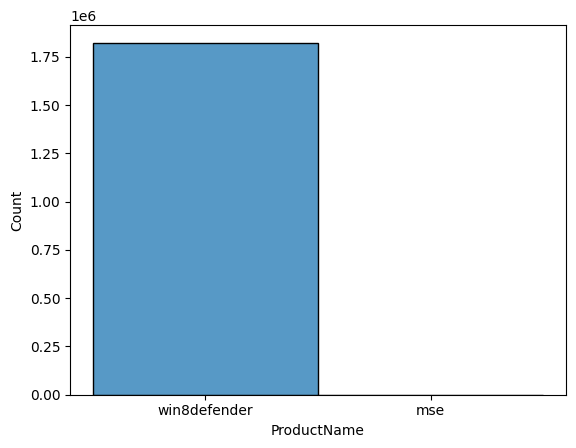

In [16]:
sns.histplot(data['ProductName'])

<Axes: xlabel='HasDetections', ylabel='count'>

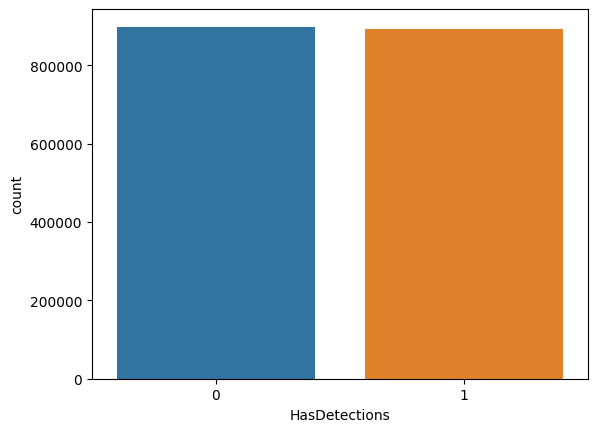

In [17]:
# How many computers had firewall enabled?
sns.countplot(x = data[data['Firewall'] == 1.0]['HasDetections'])

In [18]:
# The version of OS used
(data['Census_OSVersion'].value_counts() > 10000).head()

Census_OSVersion
10.0.17134.228      True
10.0.16299.431      True
10.0.17134.165      True
10.0.10240.17443    True
10.0.16299.371      True
Name: count, dtype: bool

In [19]:
data[data['HasDetections'] == 1]['Census_TotalPhysicalRAM'].value_counts().head(10)

Census_TotalPhysicalRAM
4096.0     455374
8192.0     195502
2048.0     125893
6144.0      51770
16384.0     35704
3072.0      16587
12288.0     15231
1024.0       5010
32768.0      3193
10240.0      1033
Name: count, dtype: int64

<Axes: >

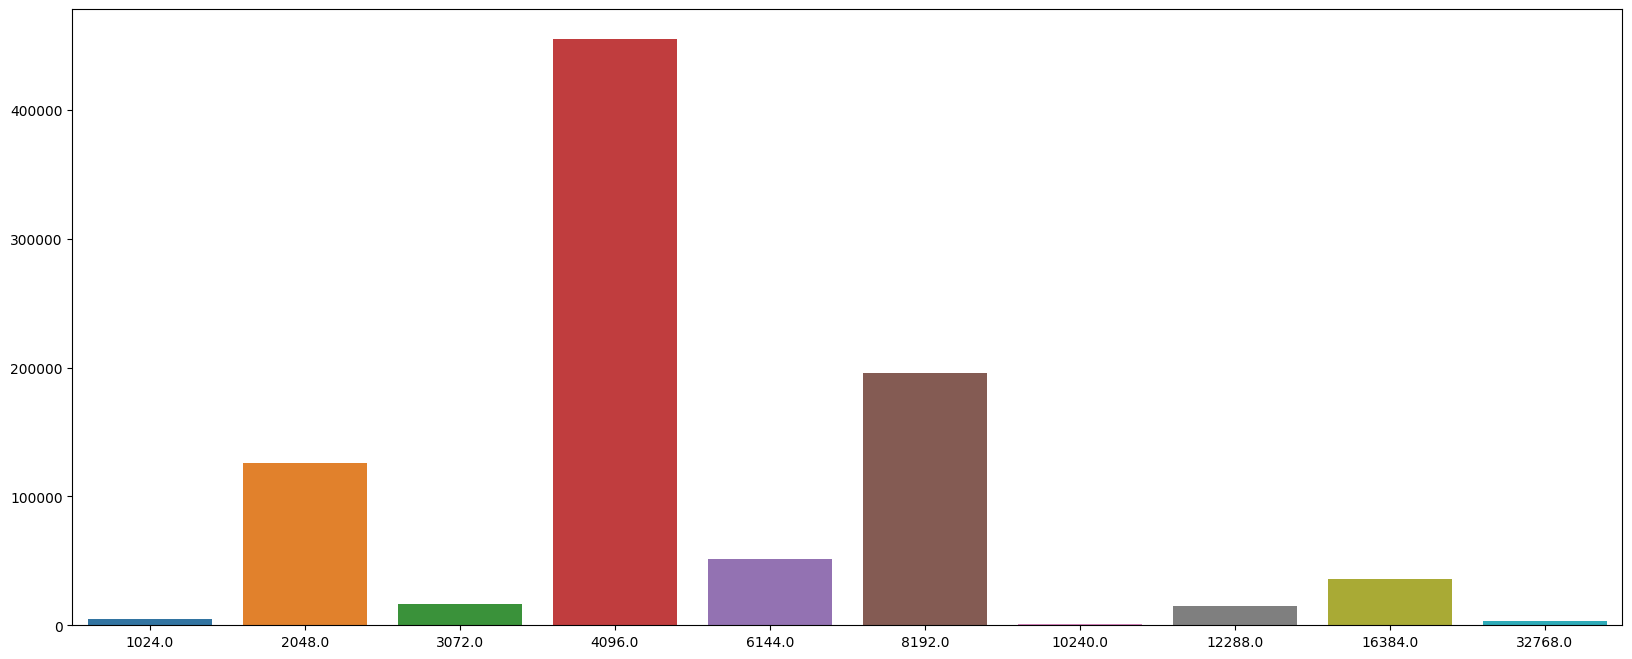

In [20]:
# How much RAM did infected PCs have?
plt.figure(figsize=(20, 8))
plt.tight_layout()
x = dict(data[data['HasDetections'] == 1]['Census_TotalPhysicalRAM'].value_counts().head(10)).keys()
y = dict(data[data['HasDetections'] == 1]['Census_TotalPhysicalRAM'].value_counts().head(10)).values()
sns.barplot(x = list(x), y = list(y))

In [21]:
data[data['HasDetections'] == 1]['HasTpm'].value_counts()

HasTpm
1    908552
0       877
Name: count, dtype: int64

<Axes: >

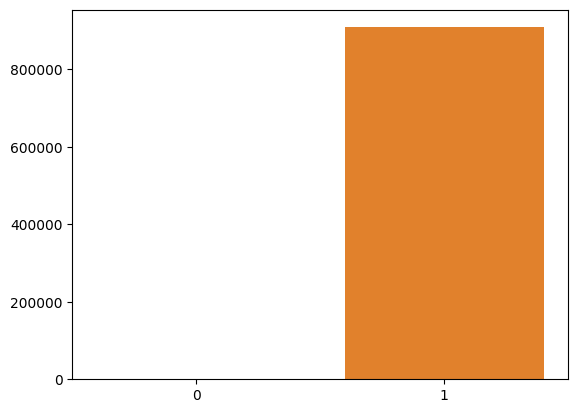

In [22]:
# How many infected PCs had TPM?
plt.tight_layout()
x = dict(data[data['HasDetections'] == 1]['HasTpm'].value_counts()).keys()
y = dict(data[data['HasDetections'] == 1]['HasTpm'].value_counts()).values()
sns.barplot(x = list(x), y = list(y))

In [23]:
data['Wdft_IsGamer'].value_counts()

Wdft_IsGamer
0.0    1418114
1.0     405436
Name: count, dtype: int64

<Axes: >

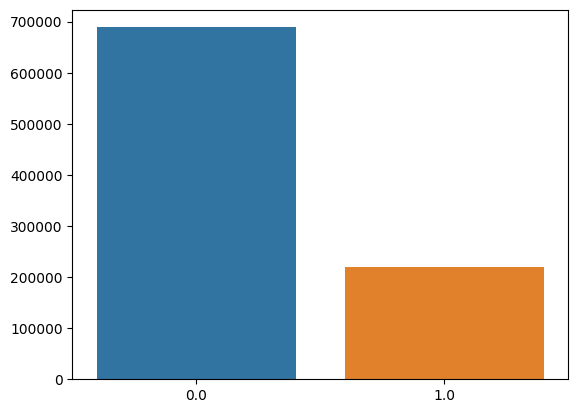

In [24]:
# How many infected PCs had gamer device configuration?
plt.tight_layout()
x = dict(data[data['HasDetections'] == 1]['Wdft_IsGamer'].value_counts()).keys()
y = dict(data[data['HasDetections'] == 1]['Wdft_IsGamer'].value_counts()).values()
sns.barplot(x = list(x), y = list(y))

In [25]:
# How many infected computers had any antivirus protection?
data[data['HasDetections'] == 1]['IsProtected'].value_counts()

IsProtected
1.0    874664
0.0     34765
Name: count, dtype: int64

In [26]:
# Status of Microsoft Smartscreen on the infected computers
data[data['HasDetections'] == 1]['SmartScreen'].value_counts()

SmartScreen
RequireAdmin    647049
ExistsNotSet    226004
Off              17147
Warn             13089
Prompt            4054
Block             1937
&#x02;              64
off                 61
&#x01;              15
On                   4
on                   3
requireadmin         2
Name: count, dtype: int64

# **Data Preprocessing**

### Label Encoding

In [27]:
# data.reset_index(drop = True, inplace = True)
# data.head()

In [28]:
# data['AppVersion'].dtypes == 'object'
data.dtypes.value_counts()

float64    34
object     27
int64      17
Name: count, dtype: int64

In [29]:
len(data['HasDetections'].value_counts())

2

In [30]:
le = LabelEncoder()
numericCols = []
for c in data.columns:
    if data[c].dtypes != 'object' and len(data[c].value_counts()) > 2:
        numericCols.append(c)
    elif data[c].dtypes == 'object':
        data[c] = le.fit_transform(data[c])

print(data.dtypes.value_counts())
print(numericCols)

int64      44
float64    34
Name: count, dtype: int64
['RtpStateBitfield', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IeVerIdentifier', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_FirmwareManufacturerIdentifier', 'Census_FirmwareVersionIdentifier', 'Wdft_RegionIdentifier'

In [31]:
# for c in data.columns:
#     if data[c].dtypes == 'float64':
#         print(data[c])

### Standard Scaling

In [32]:
# df_copy = data.copy()
# df_copy = df_copy.drop(columns=['HasDetections'])
# scaler = StandardScaler()
# data_scaled = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)
# data_scaled['HasDetections'] = data['HasDetections']

In [33]:
# for c in numericCols:
#     data[c] = scaler.fit_transform(data[c].values.reshape(-1, 1))

In [34]:
# data.head()

### Normalisation

In [35]:
list(data.columns)[:-1]

['MachineIdentifier',
 'ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalRAM',
 'Census_ChassisTypeName',
 'Census_Inter

In [36]:
# data_norm = pd.DataFrame(normalize(data.drop("HasDetections", axis = 1)), columns=list(data.columns)[:-1])
# data_norm["HasDetections"] = data["HasDetections"]
# print(data_norm.shape)
# data_norm.head()

In [37]:
# data_norm["HasDetections"].isnull().sum()

# Feature Engineering

In [38]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import pandas as pd
# import numpy as np

# # Assuming df is your DataFrame and 'target' is the column you're interested in
# X = data.drop('HasDetections', axis=1)
# y = data['HasDetections']

# # Standardizing the features
# # X = StandardScaler().fit_transform(X)

# # Perform PCA
# pca = PCA(n_components=50)
# principalComponents = pca.fit_transform(X)

# # Create a DataFrame with the principal components
# principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component ' + str(i) for i in range(1, 51)])

# # Concatenate the target column
# finalDf = pd.concat([principalDf, data[['HasDetections']]], axis = 1)

# # print(finalDf)HasDetections
# finalDf.head()

In [39]:
# print(len(list(top_features)))

In [40]:
# dataPCA = pd.DataFrame()
# for c in tqdm(list(top_features)):
#     dataPCA[c] = data[c]

# dataPCA['HasDetections'] = data['HasDetections']

In [41]:
# dataPCA.head()

In [42]:
# df = pd.DataFrame()
# l = []
# # data_scaled[data_scaled['HasDetections'] == 1]
# l.append(data_scaled[data_scaled['HasDetections'] == 1].sample(n = 50000))
# l.append(data_scaled[data_scaled['HasDetections'] == 0].sample(n = 50000))
# df = pd.concat(l)
# df.head()
# df.shape

In [43]:
# df = pd.DataFrame()
# l = []
# # data_scaled[data_scaled['HasDetections'] == 1]
# l.append(data_norm[data_norm['HasDetections'] == 1].sample(n = 100000))
# l.append(data_norm[data_norm['HasDetections'] == 0].sample(n = 100000))
# df = pd.concat(l)
# df.head()
# df.shape

In [44]:
df = pd.DataFrame()
l = []
# data_scaled[data_scaled['HasDetections'] == 1]
l.append(data[data['HasDetections'] == 1].sample(n = 50000))
l.append(data[data['HasDetections'] == 0].sample(n = 50000))
df = pd.concat(l)
df.head()
df.shape

(100000, 78)

In [45]:
df['HasDetections'].value_counts()

HasDetections
1    50000
0    50000
Name: count, dtype: int64

In [46]:
# len(df[0])

In [47]:
# Splitting the dataset

In [52]:
x = df.drop("HasDetections", axis = 1)
y = df['HasDetections']
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x)
pca = PCA(n_components=10)
x_pca = pca.fit_transform(x)
df_pca = pd.DataFrame(x_pca, columns=[f'PC{i+1}' for i in range(10)])
df_pca['HasDetections'] = y.values
x = df_pca.drop("HasDetections", axis = 1)
y = df_pca['HasDetections']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42, stratify = y)

In [53]:
df_pca.shape

(100000, 11)

# Models

#### 1. Linear SVC

In [ ]:
modelSVC = SVC()
start = time()
modelSVC.fit(x_train, y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_SVC = modelSVC.predict(x_test)
acc = accuracy_score(pred_SVC , y_test)
cm = confusion_matrix(pred_SVC , y_test)
cr = classification_report(pred_SVC , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

#### 2. LGBM

In [ ]:
modelLGBM = LGBMClassifier()
start = time()
modelLGBM.fit(x_train , y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_LGBM = modelLGBM.predict(x_test)
acc = accuracy_score(pred_LGBM , y_test)
cm = confusion_matrix(pred_LGBM , y_test)
cr = classification_report(pred_LGBM , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

In [ ]:
lgbm = LGBMClassifier()
param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': [31, 50, 70, 100],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500]
}
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=2, cv = 2)
grid_search.fit(x_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 576 candidates, totalling 1152 fits
[LightGBM] [Info] Number of positive: 17500, number of negative: 17500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31; total time=   4.0s
[LightGBM] [Info] Number of positive: 17500, number of negative: 17500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 10
[LightGBM] [Info] [bin

#### 3. Random Forest

In [54]:
model_RF = RandomForestClassifier(n_jobs=-1)
start = time()
model_RF.fit(x_train, y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_RF = model_RF.predict(x_test)
acc = accuracy_score(pred_RF , y_test)
cm = confusion_matrix(pred_RF , y_test)
cr = classification_report(pred_RF , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

--------------------------------------------------------
Time taken: 14.350777864456177 seconds
--------------------------------------------------------
0.5832666666666667
--------------------------------------------------------
[[8908 6410]
 [6092 8590]]
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.58      0.59     15318
           1       0.57      0.59      0.58     14682

    accuracy                           0.58     30000
   macro avg       0.58      0.58      0.58     30000
weighted avg       0.58      0.58      0.58     30000

--------------------------------------------------------


In [55]:
cv_scores = cross_val_score(model_RF, x, y, cv=5, scoring='accuracy')
print(cv_scores)

[0.5824  0.5782  0.58055 0.58    0.5843 ]


#### 4. ANN

In [ ]:
# x_lstm = np.array(x)
# y_lstm = np.array(y)
# x_lstm = x_lstm.reshape((x_lstm.shape[0], x_lstm.shape[1], 1))
# x_train1, x_test1, y_train1, y_test1 = train_test_split(x_lstm, y_lstm, test_size=0.30, random_state=42)
# model = keras.Sequential([
#     keras.layers.LSTM(256, activation='relu', return_sequences=True),
#     keras.layers.LSTM(512, activation='relu'),
# #     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.Accuracy()])

# start = time()
# history = model.fit(x_train1, y_train1, epochs=5, batch_size=32)
# end = time()
# print("--------------------------------------------------------")
# print(f"Time taken: {end - start} seconds")
# print("--------------------------------------------------------")
# pred_ANN = model.predict(x_test)

#### 5. Logistic Regression

In [ ]:
model_lr = LogisticRegression(n_jobs = -1, max_iter=1000)
start = time()
model_lr.fit(x_train, y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_lr = model_lr.predict(x_test)
acc = accuracy_score(pred_lr , y_test)
cm = confusion_matrix(pred_lr , y_test)
cr = classification_report(pred_lr , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

#### 6. Decision Trees

In [ ]:
model_DT = DecisionTreeClassifier()
start = time()
model_DT.fit(x_train, y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_DT = model_DT.predict(x_test)
acc = accuracy_score(pred_DT , y_test)
cm = confusion_matrix(pred_DT , y_test)
cr = classification_report(pred_DT , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

#### 7. K-Nearest Neighbours

In [ ]:
model_KN = KNeighborsClassifier()
start = time()
model_KN.fit(x_train, y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_KN = model_KN.predict(x_test)
acc = accuracy_score(pred_KN , y_test)
cm = confusion_matrix(pred_KN , y_test)
cr = classification_report(pred_KN , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

#### 8. MLP Classifier

In [ ]:
model_NN = MLPClassifier()
start = time()
model_NN.fit(x_train, y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_NN = model_NN.predict(x_test)
acc = accuracy_score(pred_NN , y_test)
cm = confusion_matrix(pred_NN , y_test)
cr = classification_report(pred_NN , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

#### 9. XGBoost

In [ ]:
model_XG = xgb.XGBClassifier()
start = time()
model_XG.fit(x_train,y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_XG = model_XG.predict(x_test)
acc = accuracy_score(pred_XG , y_test)
cm = confusion_matrix(pred_XG , y_test)
cr = classification_report(pred_XG , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

#### 10. AdaBoost

In [ ]:
model_ada = AdaBoostClassifier()
start = time()
model_ada.fit(x_train,y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_ada = model_ada.predict(x_test)
acc = accuracy_score(pred_ada , y_test)
cm = confusion_matrix(pred_ada , y_test)
cr = classification_report(pred_ada , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")

#### 12. Gaussian Naive Bayes

In [ ]:
model_gnb = GaussianNB()
start = time()
model_gnb.fit(x_train,y_train)
end = time()
print("--------------------------------------------------------")
print(f"Time taken: {end - start} seconds")
print("--------------------------------------------------------")
pred_gnb = model_gnb.predict(x_test)
acc = accuracy_score(pred_gnb , y_test)
cm = confusion_matrix(pred_gnb , y_test)
cr = classification_report(pred_gnb , y_test)
print(acc)
print("--------------------------------------------------------")
print(cm)
print("--------------------------------------------------------")
print(cr)
print("--------------------------------------------------------")